# DVSG Demo

This notebook demonstrates how you can calculate DVSG using products from the SDSS-IV MaNGA survey, accesseed through the Marvin interface. This includes map loading, preprocessing, DVSG calculation, and visualisation.

## Environment + dependency notes

Recommended environment: `environment-manga.yml` (`dvsg-manga-env`).

If kernel dependencies have been upgraded and Marvin imports fail, reinstall compatible notebook packages in the same environment:

```bash
conda activate dvsg-manga-env
python -m pip install --upgrade "setuptools<81" "packaging==20.9" "ipykernel==6.29.5"
python -m ipykernel install --user --name dvsg-manga-env --display-name "Python (dvsg-manga-env)"
```

In [1]:
import sys

try:
    import smplotlib
except ImportError:
    smplotlib = None
import matplotlib.pyplot as plt

import marvin
from marvin import config
from marvin.tools import Image

from dvsg.helpers import load_maps, load_map_coords
from dvsg.preprocessing import (
    mask_velocity_maps, 
    mask_binned_map, 
    apply_bin_snr_threshold, 
    apply_sigma_clip, 
    normalise_map, 
    preprocess_maps_from_plateifu
)
from dvsg.calculations import (
    calculate_dvsg, 
    calculate_dvsg_error,
    calculate_dvsg_residual,
    calculate_dvsg_diagnostics_from_plateifu
)
from dvsg.plotting import reconstruct_stellar_gas_residual_maps, plot_stellar_gas_residual_visual_maps

print(f'Python: {sys.version.split()[0]}')
print(f'marvin: {marvin.__version__}')

[INFO]: No release version set. Setting default to DR17
[WARNING]: /Users/Jonah/opt/anaconda3/envs/dvsg-manga-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Python: 3.11.14
marvin: 2.8.2


## Calculation

Let's calculate the DVSG value of one of the MaNGA galaxy in Fig. 1 of Powley et al. (submitted)

In [2]:
# Plateifu of the target galaxy
plateifu = '8260-9101'

# Pipeline settings
dvsg_kwargs = {
    'mode': 'remote',  # switch to 'local' if using local DAP products
    'bintype': 'VOR10',  # MaNGA binning scheme to use
    'snr_threshold': 10,  # S/N threshold for binning
    'n_sigma': 3,  # number of standard deviations for outlier rejection
    'return_residual': True,  # whether to return the stellar-gas residual maps
}

config.setDR('DR17')
config.switchSasUrl(sasmode='mirror')

dvsg_kwargs

{'mode': 'remote',
 'bintype': 'VOR10',
 'snr_threshold': 10,
 'n_sigma': 3,
 'return_residual': True}

Load the original MaNGA DAP products

In [7]:
sv_map, gv_map, sv_mask, gv_mask, sv_ivar, gv_ivar, bin_ids, bin_snr = load_maps(plateifu, **dvsg_kwargs)

Preprocess these maps as specified by `dvsg_kwargs`

In [8]:
# Extract masked values and flatten
sv_flat, gv_flat = mask_velocity_maps(sv_map, gv_map, sv_mask, gv_mask, bin_ids)
bin_snr_flat = mask_binned_map(bin_snr, sv_mask, bin_ids)  # use stellar velocity mask

# Apply SNR threshold
if dvsg_kwargs.get("snr_threshold") is not None:
    sv_flat, gv_flat = apply_bin_snr_threshold(sv_flat, gv_flat, bin_snr_flat, **dvsg_kwargs)

# Sigma clip and normalise maps
sv_clip, gv_clip = apply_sigma_clip(sv_flat, gv_flat, **dvsg_kwargs)
sv_norm, gv_norm = normalise_map(sv_clip, gv_clip, **dvsg_kwargs)

The `calculations.py` module can calculate DVSG from these products directly

In [9]:
dvsg = calculate_dvsg(sv_norm, gv_norm)
dvsg_err = calculate_dvsg_error(sv_ivar, gv_ivar, sv_mask, gv_mask)
residual = calculate_dvsg_residual(sv_norm, gv_norm)

`calculations.py` also provides a function to calculate DVSG from a MaNGA plateifu

In [10]:
out = calculate_dvsg_diagnostics_from_plateifu(plateifu, **dvsg_kwargs)

print('DVSG:', out['dvsg'])
print('DVSG error:', out.get('dvsg_err'))
print('Returned keys:', list(out.keys()))

DVSG: 0.05675604601268682
DVSG error: 0.0009432999928245194
Returned keys: ['dvsg', 'dvsg_err', 'residual']


## Visualisation

Let's visualise this! The `plotting.py` module allows you reconstruct the from the flattened binned products used in the DVSG calculation. This can be done correctly from a MaNGA plateifu

In [11]:
sv_norm_recon, gv_norm_recon, residual_recon = reconstruct_stellar_gas_residual_maps(plateifu, **dvsg_kwargs)

These maps can be plotted directly onto axes

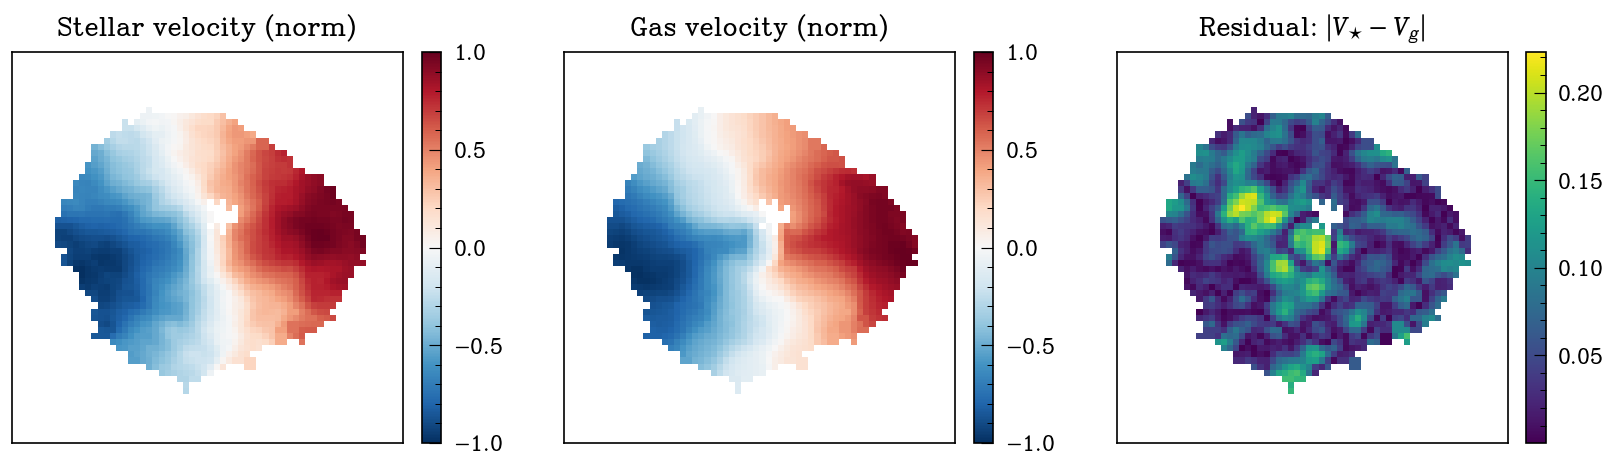

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

im0 = ax[0].imshow(sv_norm_recon, cmap='RdBu_r', origin='lower')
ax[0].set_title('Stellar velocity (norm)')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(gv_norm_recon, cmap='RdBu_r', origin='lower')
ax[1].set_title('Gas velocity (norm)')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(residual_recon, cmap='viridis', origin='lower')
ax[2].set_title(r'Residual: $|V_{\star}-V_g|$')
ax[2].text(0.98, 0.02, f"DVSG = {out['dvsg']:.3f}", transform=ax[2].transAxes, ha='right', va='bottom', color='w')
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.tight_layout()

Finally, let's add the SDSS image like in Fig. 1 of Powley et al. (submitted).

In [13]:
def plot_stellar_gas_residual_visual_maps_on_axes(ax, 
                                                  plateifu: str, 
                                                  dvsg_kwargs: dict, 
                                                  plot_kwargs: dict, 
                                                  dvsg: float = None, 
                                                  dvsg_err: float = None
                                                  ):

    # Maps
    x_as, y_as, bin_ra, bin_dec = load_map_coords(plateifu, **dvsg_kwargs)
    
    # Image
    image = Image(plateifu)
    image_data = image.data

    # Normalised reconstructed maps
    sv_norm_recon, gv_norm_recon, residual_recon = reconstruct_stellar_gas_residual_maps(plateifu, **dvsg_kwargs)

    # DVSG and error
    if dvsg is not None:
        pass
    else:
        output = calculate_dvsg_diagnostics_from_plateifu(plateifu, **dvsg_kwargs)
        dvsg = output["dvsg"]
        dvsg_err = output["dvsg_err"]

    # Plot maps on axes
    ax = plot_stellar_gas_residual_visual_maps(ax, 
                                               plateifu,
                                               x_as, y_as,
                                               bin_ra, bin_dec,
                                               sv_norm_recon, gv_norm_recon, residual_recon, image_data,
                                               dvsg,
                                               dvsg_kwargs,
                                               dvsg_err,
                                               plot_kwargs=plot_kwargs
    )

    return ax

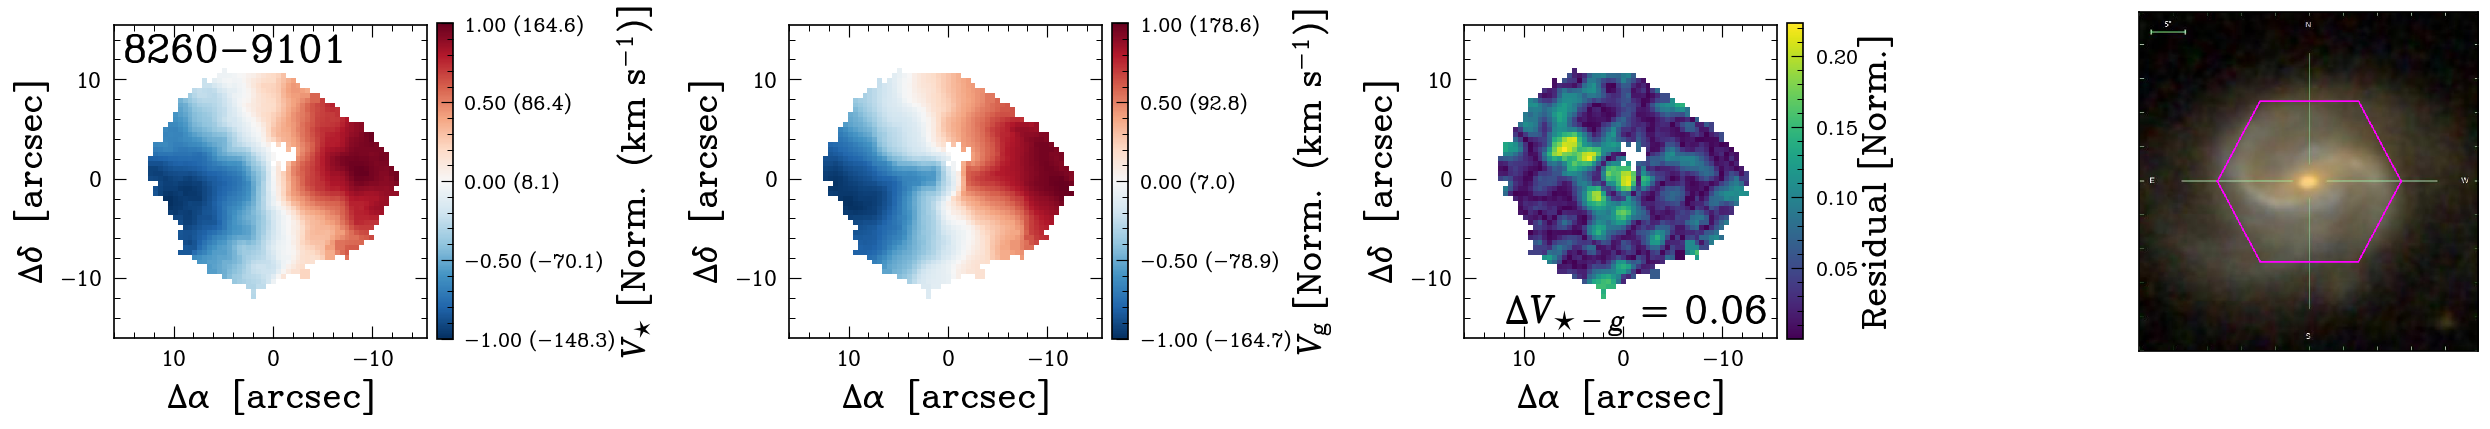

In [14]:
# Plot kwargs
plot_kwargs = {
    "labelpad": 0,
    "tcksize": 14,
    "labsize": 24,
    "txtsize": 28,
    "plot_error": False,
}

# Create figure
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(21, 5))

# Plot maps
ax = plot_stellar_gas_residual_visual_maps_on_axes(ax, plateifu, dvsg_kwargs, plot_kwargs)

fig.tight_layout()